In [1]:
import mxnet as mx
import numpy
import matplotlib.pyplot as plt
import pandas
import logging
import csv

In [2]:
# Load the MNIST data
#mnist = mx.test_utils.get_mnist()

In [61]:
batch_size = 100
#train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
#val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)
#training_data = numpy.genfromtxt('data/train.csv', delimiter=',')
#len(training_data)
#len(training_data[1])

In [4]:
usecols = [i for i in range(1, 785)];
usecols
testcols = [i for i in range(0, 785)]
#training_csv = numpy.loadtxt('data/train_orig.csv', delimiter=',', unpack=True, usecols = 0)
label_csv = numpy.loadtxt('data/train_orig.csv', delimiter = ',', usecols = 0, skiprows = 1, dtype = int)
train_csv = numpy.loadtxt('data/train_orig.csv', delimiter = ',', usecols = usecols, skiprows = 1, dtype = float)
#train_iter = mx.io.CSVIter(data_csv = 'data/train.csv', data_shape = (784,), label_csv = 'data/label.csv', label_shape = (1,), batch_size = batch_size)
#val_iter = mx.io.CSVIter(data_csv = 'data/test.csv', data_shape = (784, ), batch_size = batch_size)

In [62]:
val_iter = mx.io.CSVIter(data_csv = 'data/test.csv', data_shape = (784, ), batch_size = batch_size)

In [63]:
#mnist['train_data'].shape
train_iter = mx.io.NDArrayIter(data = train_csv, label = label_csv, batch_size = batch_size)
type(train_iter)
#type(val_iter)

mxnet.io.NDArrayIter

In [7]:
#mnist['train_label'].shape

In [8]:
# Lets look at the distribution of training data
#xbins = [x for x in range(0, 11)]
#plt.hist(mnist['train_label'], xbins)
#plt.show()

In [64]:
data = mx.sym.var('data')
#data = mx.sym.flatten(data=data)


In [65]:
# The first fully-connected layer and the corresponding activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=128)
act1 = mx.sym.Activation(data=fc1, act_type="relu")

# The second fully-connected layer and the corresponding activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64)
act2 = mx.sym.Activation(data=fc2, act_type="relu")

fc3  = mx.sym.FullyConnected(data=act2, num_hidden = 256)
act3 = mx.sym.Activation(data=fc3, act_type="tanh")

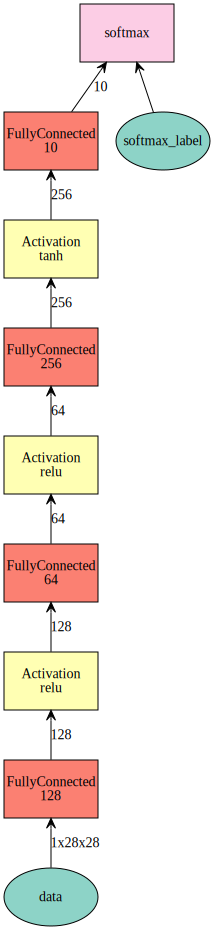

In [66]:
# MNIST has 10 classes
fc4  = mx.sym.FullyConnected(data=act3, num_hidden=10)
# Softmax with cross entropy loss
mlp  = mx.sym.SoftmaxOutput(data=fc4, name='softmax')
shape = {"data" : (batch_size, 1, 28, 28)}
mx.viz.plot_network(symbol=mlp, shape=shape)

In [12]:
# conv1 = mx.sym.Convolution(data=data, kernel=(5,5), num_filter=20)
# tanh1 = mx.sym.Activation(data=conv1, act_type="tanh")
# pool1 = mx.sym.Pooling(data=tanh1, pool_type="max", kernel=(2,2), stride=(2,2))
# # second conv layer
# conv2 = mx.sym.Convolution(data=pool1, kernel=(5,5), num_filter=50)
# tanh2 = mx.sym.Activation(data=conv2, act_type="tanh")
# pool2 = mx.sym.Pooling(data=tanh2, pool_type="max", kernel=(2,2), stride=(2,2))
# # first fullc layer
# flatten = mx.sym.flatten(data=pool2)
# fc1 = mx.symbol.FullyConnected(data=flatten, num_hidden=500)
# tanh3 = mx.sym.Activation(data=fc1, act_type="tanh")
# # second fullc
# fc2 = mx.sym.FullyConnected(data=tanh3, num_hidden=10)
# # softmax loss
# lenet = mx.sym.SoftmaxOutput(data=fc2, name='softmax')

In [67]:
logging.getLogger().setLevel(logging.DEBUG)  # logging to stdout
# create a trainable module on CPU
mlp_model = mx.mod.Module(symbol=mlp, context=mx.cpu())

mlp_model.fit(train_iter,  # train data
              eval_data=None,  # validation data
              optimizer='sgd',  # use SGD to train
              optimizer_params={'learning_rate':0.1},  # use fixed learning rate
              eval_metric='acc',  # report accuracy during training
              batch_end_callback = mx.callback.Speedometer(batch_size, 50), # output progress for each 100 data batches
              num_epoch=1)  # train for at most 10 dataset passes


INFO:root:Epoch[0] Batch [50]	Speed: 40017.56 samples/sec	accuracy=0.191569
INFO:root:Epoch[0] Batch [100]	Speed: 52028.57 samples/sec	accuracy=0.465200
INFO:root:Epoch[0] Batch [150]	Speed: 52300.79 samples/sec	accuracy=0.702200
INFO:root:Epoch[0] Batch [200]	Speed: 52034.64 samples/sec	accuracy=0.819600
INFO:root:Epoch[0] Batch [250]	Speed: 50588.88 samples/sec	accuracy=0.884400
INFO:root:Epoch[0] Batch [300]	Speed: 51413.89 samples/sec	accuracy=0.885400
INFO:root:Epoch[0] Batch [350]	Speed: 52010.76 samples/sec	accuracy=0.913400
INFO:root:Epoch[0] Batch [400]	Speed: 51157.04 samples/sec	accuracy=0.929200
INFO:root:Epoch[0] Train-accuracy=0.923684
INFO:root:Epoch[0] Time cost=0.864


In [ ]:
# lenet_model = mx.mod.Module(symbol=lenet, context=mx.cpu())
# # train with the same
# lenet_model.fit(train_iter,
#                 eval_data=None,
#                 optimizer='sgd',
#                 optimizer_params={'learning_rate':0.1},
#                 eval_metric='acc',
#                 batch_end_callback = mx.callback.Speedometer(batch_size, 100),
#                 num_epoch=10)

In [58]:
testcols = [x for x in range(0, 784)]
test_csv = numpy.genfromtxt('data/test.csv', delimiter = ',', usecols = testcols, dtype = float)


In [68]:
lenOutput = len(test_csv);
lenOutput
prob = mlp_model.predict(val_iter)
prob.shape


(28001, 10)

In [69]:

with open('output.csv', 'w') as outputFile:
    outputWriter = csv.writer(outputFile, delimiter=',');
    outputWriter.writerow(['ImageId','Label']);
    imageId = 1;
    for i in range(0, lenOutput-1):
        output = prob[i]
        outputWriter.writerow([str(imageId)] + [str(numpy.argmax(output.asnumpy()))]);
        imageId += 1
        #print('Classified as %d with probability %f' % (numpy.argmax(output.asnumpy()), max(output.asnumpy())))
